In [3]:
# Dataframe
import pandas as pd
import numpy as np

# Split Data
from sklearn.model_selection import train_test_split

# Preprocessing dan Layer
import sklearn.preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import r2_score

# Visualisasi Plot
import matplotlib.pyplot as plt
from plotly import graph_objs as go

In [4]:
df = pd.read_csv('/content/COMED_hourly.csv')
df

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0
...,...,...
66492,2018-01-01 20:00:00,13858.0
66493,2018-01-01 21:00:00,13758.0
66494,2018-01-01 22:00:00,13627.0
66495,2018-01-01 23:00:00,13336.0


In [5]:
df.isnull().sum()

Datetime    0
COMED_MW    0
dtype: int64

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['COMED_MW']=scaler.fit_transform(df['COMED_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape


(66497, 2)

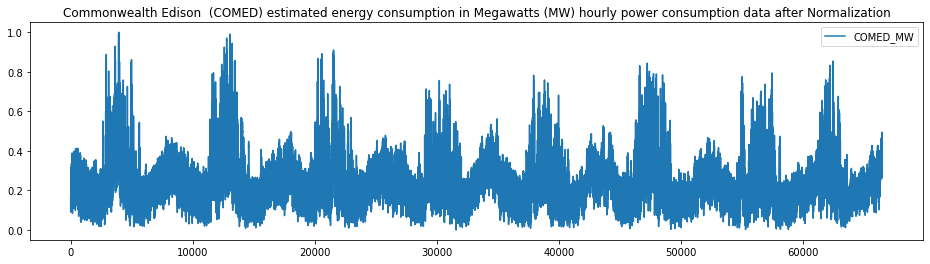

In [7]:
df_norm.plot(figsize=(16,4),legend=True)
plt.title('Commonwealth Edison  (COMED) estimated energy consumption in Megawatts (MW) hourly power consumption data after Normalization')
plt.show()

In [8]:
dates = df['Datetime'].values
aep = df['COMED_MW'].values

In [9]:
df.dtypes

Datetime     object
COMED_MW    float64
dtype: object

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(aep, dates, train_size=0.8, test_size=0.2, shuffle=False )

In [11]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  53197
Total Data Validation :  13300


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
                                    Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    Bidirectional(tf.keras.layers.LSTM(60, dropout=0.2)),
                                    Dense(16, activation="relu"),
                                    Dropout(0.2),
                                    Dense(8, activation="relu"),
                                    Dense(1),
])

In [14]:
minMae = (df['COMED_MW'].max() - df['COMED_MW'].min()) * 10/100
print(minMae)

0.1


In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < minMae and logs.get('val_mae') < minMae):
      print("\MAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[callbacks])


Epoch 1/100
266/266 [==============================] - 26s 54ms/step - loss: 0.0349 - mae: 0.2207 - val_loss: 0.0217 - val_mae: 0.1646
Epoch 2/100
266/266 [==============================] - 13s 47ms/step - loss: 0.0209 - mae: 0.1564 - val_loss: 0.0137 - val_mae: 0.1217
Epoch 3/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0147 - mae: 0.1255 - val_loss: 0.0104 - val_mae: 0.1049
Epoch 4/100
266/266 [==============================] - 12s 46ms/step - loss: 0.0120 - mae: 0.1122 - val_loss: 0.0092 - val_mae: 0.0994
Epoch 5/100
266/266 [==============================] - 12s 46ms/step - loss: 0.0108 - mae: 0.1069 - val_loss: 0.0088 - val_mae: 0.0983
Epoch 6/100
266/266 [==============================] - 12s 46ms/step - loss: 0.0103 - mae: 0.1048 - val_loss: 0.0087 - val_mae: 0.0988
Epoch 7/100
266/266 [==============================] - 13s 47ms/step - loss: 0.0100 - mae: 0.1043 - val_loss: 0.0087 - val_mae: 0.0996
Epoch 8/100
266/266 [==============================] - 

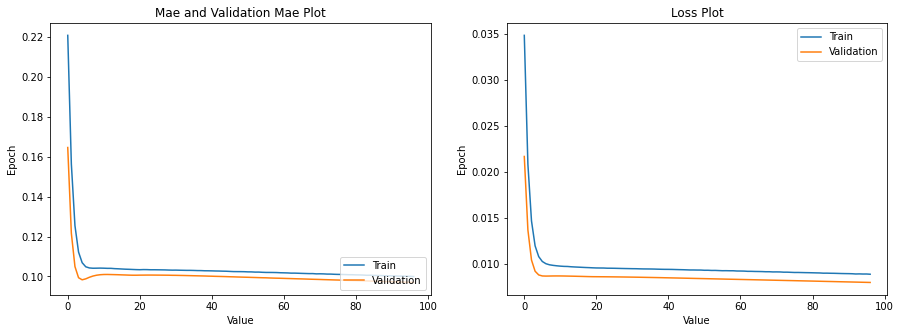

In [17]:
figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mae and Validation Mae Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()